# Zarr v3 Demo

**What we will discuss**
- Create arrays and groups in a Zarr store
- Store/read JSON metadata via attributes
- Configure chunking and compression (codec pipeline)
- Work with ZIP stores


## Imports

In [1]:
# Environment check — versions & runtime
import sys, platform
import numpy as np
import zarr

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("Zarr:", zarr.__version__)


Python: 3.12.11
Platform: macOS-15.6.1-x86_64-i386-64bit
NumPy: 2.3.2
Zarr: 3.1.2


## Create a store

In [2]:
# Set Zarr version to use (2 or 3)
ZARRVERSION = 3  # Specify Zarr version

# Create data to store in the Zarr store
data = np.random.rand(100, 100).astype('float32')

# Create a larger sparse array
sparse_data = np.random.rand(1000, 1000).astype('float32')
sparse_data[sparse_data < 0.8] = 0  # Make it sparse

rnd_fpath = 'Testing/random_example.zarr'
sparse_fpath = 'Testing/sparse_example.zarr'
# For Zarr v3, use codecs instead of compressor
if ZARRVERSION == 2:
    """ 
    Customise compressor OPTIONAL it might improve compression rate
    """
    compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
    zarr_store = zarr.open(rnd_fpath, mode='w', shape=data.shape, dtype=data.dtype, compressor=compressor, chunks=(50, 50))
    sparse_zarr_store = zarr.open(sparse_fpath, mode='w', shape=sparse_data.shape, dtype=sparse_data.dtype, compressor=compressor, chunks=(100, 100))

else:
    """
    # OPTIONAL codecs configuration for Zarr v3
    from zarr.codecs import BytesCodec, BloscCodec, BloscCname, BloscShuffle
    codecs = [BytesCodec(endian='little'),
              BloscCodec(cname=BloscCname.zstd,
                         clevel=3,
                         shuffle=BloscShuffle.bitshuffle,
                         typesize=4)
              ]
    zarr_store = zarr.open('example.zarr', mode='w', shape=data.shape, dtype=data.dtype, codecs=codecs)
    """
    zarr_store = zarr.open(rnd_fpath, mode='w', shape=data.shape, dtype=data.dtype)
    sparse_zarr_store = zarr.open(sparse_fpath, mode='w', shape=sparse_data.shape, dtype=sparse_data.dtype)

zarr_store[:] = data
sparse_zarr_store[:] = sparse_data

print("Data written to Zarr store 'random_example.zarr'.")
print("Data written to Zarr store 'sparse_example.zarr'.")


Data written to Zarr store 'random_example.zarr'.
Data written to Zarr store 'sparse_example.zarr'.


### Explanation of Zarr Store Creation

```python
zarr.open(
    'example.zarr',
    mode='w',
    shape=data.shape,
    dtype=data.dtype,
    compressor=zarr.Blosc(cname='zstd', clevel=3, shuffle=2),
    chunks=(50, 50)  # Optional: specify chunk size
)
```

- **'example.zarr'**: Path to the Zarr store on disk.
- **mode='w'**: Write mode; creates a new store or overwrites an existing one.
- **shape=data.shape**: Shape of the array to store (e.g., (100, 100)).
- **dtype=data.dtype**: Data type of the array (e.g., float32).
- **compressor=zarr.Blosc(...)**: Use Blosc compressor with Zstandard codec, compression level 3, and byte shuffling.
- **chunks=(50, 50)**: (Optional) Store data in 50x50 blocks for efficient access and better compression.

**Codecs reference**: [Zarr Codecs Documentation](https://zarr-specs.readthedocs.io/en/latest/v3/codecs/index.html)

**Using chunks is recommended** for large arrays, as it might improve read/write performance and compression.

To determine optimal chunk size, consider the access patterns of your data and experiment with different sizes.

## Load the data from the Zarr store

In [3]:
# Load data from the Zarr store
loaded_data = zarr.open('Testing/sparse_example.zarr', mode='r')
print("Data loaded from Zarr store 'sparse_example.zarr':")
print(loaded_data[:])

Data loaded from Zarr store 'sparse_example.zarr':
[[0.         0.         0.9356636  ... 0.         0.9549631  0.        ]
 [0.         0.         0.         ... 0.9292909  0.9676499  0.94326913]
 [0.         0.         0.         ... 0.         0.8459375  0.        ]
 ...
 [0.         0.         0.         ... 0.88472307 0.         0.        ]
 [0.         0.         0.83324087 ... 0.         0.         0.        ]
 [0.9681366  0.         0.         ... 0.         0.         0.        ]]


## Compare size of compressed vs uncompressed data

In [4]:
# Compare size of compressed vs uncompressed data
original_size = data.nbytes
zarr_size = zarr_store.nbytes_stored() if ZARRVERSION == 3 else zarr_store.nbytes_stored
sparse_original_size = sparse_data.nbytes
sparse_zarr_size = sparse_zarr_store.nbytes_stored() if ZARRVERSION == 3 else sparse_zarr_store.nbytes_stored
print(f"Original data size: {original_size} bytes")
print(f"Zarr stored data size: {zarr_size} bytes")
print("Compression rate for dense data: {:.2f}%".format((1 - zarr_size / original_size) * 100))
print(f"Sparse original data size: {sparse_original_size} bytes")
print(f"Sparse Zarr stored data size: {sparse_zarr_size} bytes")
print("Compression rate for sparse data: {:.2f}%".format((1 - sparse_zarr_size / sparse_original_size) * 100))

Original data size: 40000 bytes
Zarr stored data size: 36441 bytes
Compression rate for dense data: 8.90%
Sparse original data size: 4000000 bytes
Sparse Zarr stored data size: 962648 bytes
Compression rate for sparse data: 75.93%


## Grouped stores
- Create a hierarchy of arrays in a single Zarr store
- Create groups (like folders) in the Zarr hierarchy

In [6]:
# Create a group structure in Zarr V2 or V3
if ZARRVERSION == 2:
    root = zarr.open('Testing/grouped_example.zarr', mode='w')
    group1 = root.create_group('group1')

    group1.create_dataset('data1', data=np.random.rand(50, 50).astype('float32'))
    group1.create_dataset('data2', data=np.random.rand(30, 30).astype('float32'))
    group2 = root.create_group('group2')
    group2.create_dataset('data3', data=np.random.rand(20, 20).astype('float32'))

    print("Data written to Zarr store 'grouped_example.zarr' with groups and datasets.")
else:
    root = zarr.open('Testing/grouped_example.zarr', mode='w')
    group1 = root.create_group('group1')
    group2 = root.create_group('group2')

    # Always specify shape for v3, and use create_array (recommended)
    group1.create_array('data1', data=np.random.rand(50, 50).astype('float32'))
    group1.create_array('data2', data=np.random.rand(30, 30).astype('float32'))
    group2.create_array('data3', data=np.random.rand(20, 20).astype('float32'))

    print("Data written to Zarr store 'grouped_example.zarr' with groups and datasets.")

Data written to Zarr store 'grouped_example.zarr' with groups and datasets.


## Set or read JSON attributes (metadata) in the grouped Zarr store

In [7]:
# Add metadata to a grouped Zarr store zarr specifications v2 (...and v3?)
root.attrs['description'] = 'This is a grouped Zarr store example'
root.attrs['version'] = '1.0'
print("Metadata added to 'grouped_example.zarr':")
print(root.attrs.asdict())

group1.attrs['group_info'] = 'This is group 1'
group1.attrs['num_datasets'] = 2
print("Metadata for group1:")
print(group1.attrs.asdict())

Metadata added to 'grouped_example.zarr':
{'description': 'This is a grouped Zarr store example', 'version': '1.0'}
Metadata for group1:
{'group_info': 'This is group 1', 'num_datasets': 2}


## Compare write and load times with pillow and zarr

In [ ]:
from time import time # Import time for performance measurement
from PIL import Image # Pillow is the standard Python Imaging Library

# Create a random rgb image 1024 x 1024 x 3, int 8
rgb_image = np.random.randint(0, 256, size=(1024, 1024, 3), dtype=np.uint8)

# Use pillow to save and load the image
img = Image.fromarray(rgb_image)
start_time = time()
img.save('Testing/random_image.png')
save_time = time() - start_time
loaded_img = Image.open('Testing/random_image.png')
loaded_rgb_image = np.array(loaded_img)
load_time = time() - (start_time + save_time)
print("Random RGB image saved and loaded using Pillow.")
print(f"Save time: {save_time:.4f} seconds")
print(f"Load time: {load_time:.4f} seconds")

# Save and load the same image using Zarr
zarr_image_store = zarr.open('Testing/random_image.zarr', 
                             mode='w', 
                             shape=rgb_image.shape, 
                             dtype=rgb_image.dtype, 
                             chunks=(512, 512, 3))
start_time = time()
zarr_image_store[:] = rgb_image
zarr_save_time = time() - start_time
start_time = time()
loaded_zarr_image = zarr.open('Testing/random_image.zarr', mode='r')
loaded_rgb_image_zarr = loaded_zarr_image[:]
zarr_load_time = time() - start_time
print("Random RGB image saved and loaded using Zarr.")
print(f"Zarr save time: {zarr_save_time:.4f} seconds")
print(f"Zarr load time: {zarr_load_time:.4f} seconds")



# Print zarr gain in load time
load_time_gain = round(load_time / zarr_load_time, 2)
print(f"Zarr load time gain: {load_time_gain} X")


Random RGB image saved and loaded using Pillow.
Save time: 0.2392 seconds
Load time: 0.0432 seconds
Random RGB image saved and loaded using Zarr.
Zarr save time: 0.0154 seconds
Zarr load time: 0.0058 seconds
Zarr load time gain: 7.48 X


### Benchmark read time pillow vs zarr with different images sizes

100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


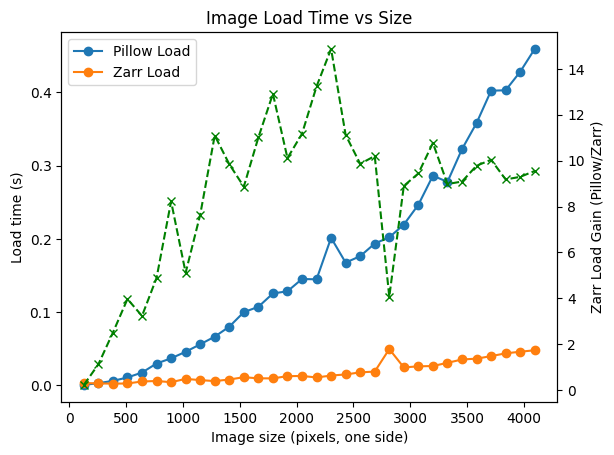

In [18]:
import numpy as np
from PIL import Image
import zarr
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

def scan_image_io(sizes):
    pillow_load, zarr_load, zarr_gain = [], [], []
    for s in tqdm(sizes):
        img = np.random.randint(0, 256, (s, s, 3), np.uint8)
        # Pillow
        Image.fromarray(img).save('Testing/tmp.png')
        t0 = time(); _ = np.array(Image.open('Testing/tmp.png')); pillow_load.append(time()-t0)
        # Zarr
        zarr.open('Testing/tmp.zarr', mode='w', shape=img.shape, dtype=img.dtype, chunks=(s,s,3))[:] = img
        t0 = time(); _ = zarr.open('Testing/tmp.zarr', mode='r')[:]; zarr_load.append(time()-t0)
        zarr_gain.append(pillow_load[-1]/zarr_load[-1] if zarr_load[-1]>0 else np.nan)
    return pillow_load, zarr_load, zarr_gain

sizes = range(128, 4097, 128)
pillow_load, zarr_load, zarr_gain = scan_image_io(sizes) 

plt.plot(sizes, pillow_load, 'o-', label='Pillow Load')
plt.plot(sizes, zarr_load, 'o-', label='Zarr Load')
plt.xlabel('Image size (pixels, one side)')
plt.ylabel('Load time (s)')
plt.legend(loc='upper left')
plt.twinx().plot(sizes, zarr_gain, 'x--g', label='Zarr Load Gain')
plt.ylabel('Zarr Load Gain (Pillow/Zarr)')
plt.title('Image Load Time vs Size')
plt.show()

## Multiple processes writing on the same Zarr store (concurrently)

In [15]:
import numpy as np
import zarr
from concurrent.futures import ThreadPoolExecutor
from time import time

In [16]:
number_of_images = 100

def write_to_zarr(image_array, zarr_path):
    root = zarr.open(zarr_path, mode='a')
    for i in range(image_array.shape[0]):
        root.create_array(f'image_{i}', data=image_array[i], chunks=(512, 512, 3))

image_array = np.array([np.random.randint(0, 256, (512, 512, 3), np.uint8) for _ in range(number_of_images)])
print(image_array.shape)

zarr_path = 'Testing/random_images.zarr'
start_time = time()
with ThreadPoolExecutor() as executor:
    executor.submit(write_to_zarr, image_array, zarr_path)
write_time = time() - start_time
print(f"{number_of_images} images written to Zarr store '{zarr_path}' in {write_time:.4f} seconds")


(100, 512, 512, 3)
100 images written to Zarr store 'Testing/random_images.zarr' in 0.0034 seconds


## ZipStore (single-file)

In [21]:
from zarr.storage import ZipStore
import numpy as np

store = ZipStore("Testing/snapshot.zip", mode="w")
za = zarr.create_array(store=store, shape=(256, 256), chunks=(64, 64), dtype="f4")
za[:] = np.ones((256, 256)).astype("f4")
store.close()
print("Wrote: Testing/snapshot.zip")

Wrote: Testing/snapshot.zip


In [22]:
# read back from the zip file
store = ZipStore("Testing/snapshot.zip", mode="r")
za = zarr.open(store=store, mode="r")
print(za[:])

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


## Create a data manager classes to handle Zarr stores

In [ ]:
"""DATA STRUCTURE:
root
  {Metadata}
  |-- Experiments
       |-- E1 (100, 100)
            {EMetadata}
       |-- E2 (40, 40)
            {EMetadata}
  |-- Results
       |-- R1 (20, 20)
       |-- R2 (20, 20)

"""
class ZarrDataManager:
    def __init__(self, zarr_path):
        self.store = zarr.open(zarr_path, mode='a')
        if 'Experiments' not in self.store:
            self.store.create_group('Experiments')
        if 'Results' not in self.store:
            self.store.create_group('Results')

    def write_metadata_root(self, key, value):
        self.store.attrs[key] = value

    def get_metadata_root(self):
        return self.store.attrs.asdict()
    
    def add_experiment(self, name, data, metadata=None):
        exp_group = self.store['Experiments'].create_group(name)
        exp_group.create_array('data', data=data, chunks=(50, 50))
        if metadata:
            for key, value in metadata.items():
                exp_group.attrs[key] = value

    def add_result(self, name, data):
        res_group = self.store['Results'].create_group(name)
        res_group.create_array('data', data=data, chunks=(20, 20))

    def get_experiment(self, name):
        return self.store['Experiments'][name]['data'][:], self.store['Experiments'][name].attrs.asdict()

    def analyse_experiment(self, name):
        data = self.store['Experiments'][name]['data'][:]
        results = data[:20, :20]
        self.add_result(name, results)

    def get_result(self, name):
        return self.store['Results'][name]['data'][:]


# Example usage
zarr_path = 'Testing/complex_data.zarr'
manager = ZarrDataManager(zarr_path)
manager.write_metadata_root('description', 'Complex data structure with experiments and results')
manager.write_metadata_root('version', '1.0')
print("Root metadata:", manager.get_metadata_root())
manager.add_experiment('E1', np.random.rand(100, 100).astype('float32'), {'type': 'test', 'date': '2024-10-01'})
manager.add_experiment('E2', np.random.rand(40, 40).astype('float32'), {'type': 'control', 'date': '2024-10-02'})
data_e1, meta_e1 = manager.get_experiment('E1')
print("Experiment E1 data shape:", data_e1.shape)
print("Experiment E1 metadata:", meta_e1)
manager.analyse_experiment('E1')
result_e1 = manager.get_result('E1')
print("Result E1 data shape:", result_e1.shape)


## Using Zarr in a Pytorch DataLoader

In [ ]:
# Example of integrating Zarr with PyTorch DataLoader: Minimal boilerplate code
import torch
from torch.utils.data import Dataset, DataLoader

class ZarrDataset(Dataset):
    def __init__(self, zarr_store:str):
        self.zarr_store = zarr.open(zarr_store, mode='r')

    def __len__(self):
        return self.zarr_store.shape[0]

    def __getitem__(self, idx):
        return self.zarr_store[idx]

data_loader_params = {
    'batch_size': 32,
    'shuffle': True,
    'num_workers': 4
}

zarr_loader = DataLoader(ZarrDataset('example.zarr'), **data_loader_params)